In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path

data_folder_path = Path().resolve().parent / "__temp_bots_Jun10_16h04m02.8s"
data_folder_path = Path().resolve().parent / "__temp_bots_Jun10_16h13m00.6s"
app_name = "network_pd.csv"

In [3]:
df = pl.read_csv(data_folder_path / app_name)
df.head()

participant.id_in_session,participant.code,participant.label,participant._is_bot,participant._index_in_pages,participant._max_page_index,participant._current_app_name,participant._current_page_name,participant.time_started_utc,participant.visited,participant.mturk_worker_id,participant.mturk_assignment_id,participant.payoff,player.id_in_group,player.role,player.payoff,player.action,player.confirm_results,player.time_out,player.current_payoff,player.neighbor_actions,player.neighbor_payoffs,player.highest_action,player.show_payoffs,group.id_in_subsession,group.dicision_start_time,group.show_payoffs,subsession.round_number,session.code,session.label,session.mturk_HITId,session.mturk_HITGroupId,session.comment,session.is_demo
i64,str,str,i64,i64,i64,str,str,str,i64,str,str,f64,i64,str,f64,i64,str,i64,i64,str,str,i64,i64,i64,f64,i64,i64,str,str,str,str,str,i64
1,"""eafdb4vv""",null,1,26,25,"""network_pd""","""ResultsWaitPage""","""2025-06-10 07:03:30.999731""",1,null,null,60.0,1,null,20.0,0,null,0,20,"""1,1,1,1""","""8,8,8,8""",0,1,2,1.7495e9,1,1,"""fsh7x47y""",null,null,null,null,0
2,"""3t9cssbc""",null,1,26,25,"""network_pd""","""ResultsWaitPage""","""2025-06-10 07:03:31.051707""",1,null,null,64.0,2,null,8.0,1,null,0,8,"""1,0,1,0""","""8,20,8,20""",0,1,2,1.7495e9,1,1,"""fsh7x47y""",null,null,null,null,0
3,"""h0l40wva""",null,1,26,25,"""network_pd""","""ResultsWaitPage""","""2025-06-10 07:03:31.072781""",1,null,null,40.0,3,null,8.0,1,null,0,8,"""0,1,0,1""","""20,8,20,8""",0,1,2,1.7495e9,1,1,"""fsh7x47y""",null,null,null,null,0
4,"""769aie3h""",null,1,26,25,"""network_pd""","""ResultsWaitPage""","""2025-06-10 07:03:31.093487""",1,null,null,64.0,4,null,20.0,0,null,0,20,"""1,1,1,1""","""8,8,8,8""",0,1,2,1.7495e9,1,1,"""fsh7x47y""",null,null,null,null,0
5,"""wn8q0x6o""",null,1,26,25,"""network_pd""","""ResultsWaitPage""","""2025-06-10 07:03:31.115523""",1,null,null,60.0,5,null,8.0,1,null,0,8,"""1,0,1,0""","""8,20,8,20""",0,1,2,1.7495e9,1,1,"""fsh7x47y""",null,null,null,null,0


In [4]:
df.columns

['participant.id_in_session',
 'participant.code',
 'participant.label',
 'participant._is_bot',
 'participant._index_in_pages',
 'participant._max_page_index',
 'participant._current_app_name',
 'participant._current_page_name',
 'participant.time_started_utc',
 'participant.visited',
 'participant.mturk_worker_id',
 'participant.mturk_assignment_id',
 'participant.payoff',
 'player.id_in_group',
 'player.role',
 'player.payoff',
 'player.action',
 'player.confirm_results',
 'player.time_out',
 'player.current_payoff',
 'player.neighbor_actions',
 'player.neighbor_payoffs',
 'player.highest_action',
 'player.show_payoffs',
 'group.id_in_subsession',
 'group.dicision_start_time',
 'group.show_payoffs',
 'subsession.round_number',
 'session.code',
 'session.label',
 'session.mturk_HITId',
 'session.mturk_HITGroupId',
 'session.comment',
 'session.is_demo']

<Axes: xlabel='sum_payoff', ylabel='Count'>

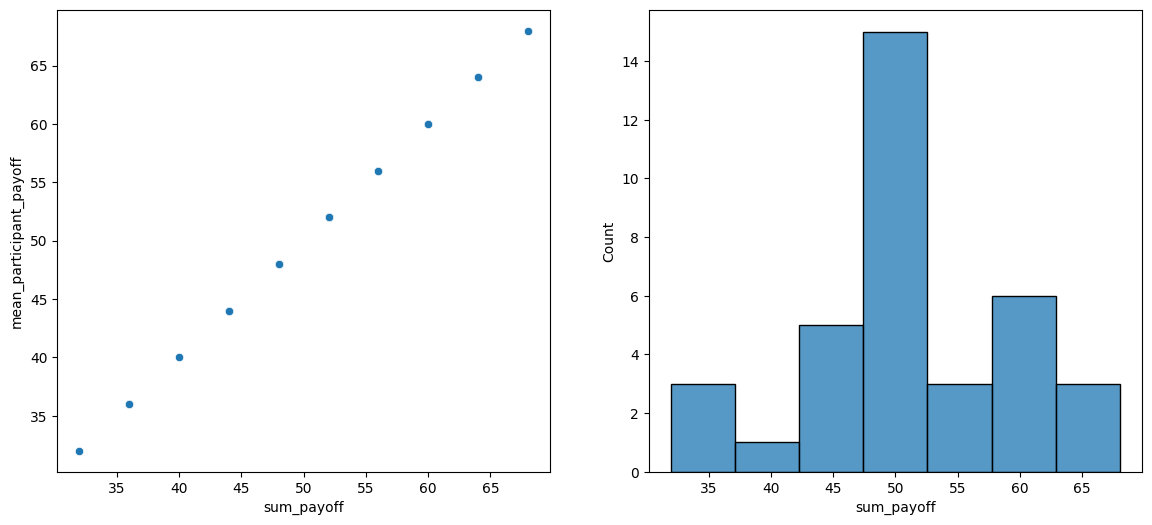

In [ ]:
# payoff の計算が大丈夫か確認する
# payoff distribution
plt_df = df.group_by("participant.id_in_session").agg(
    pl.col("player.payoff").sum().alias("sum_payoff"),
    pl.col("participant.payoff").mean().alias("mean_participant_payoff"),
)



fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=plt_df.to_pandas(),

    x="sum_payoff",
    y="mean_participant_payoff",
    ax=axes[0],
)

sns.histplot(
    plt_df.to_pandas(),
    x="sum_payoff",

    ax=axes[1],
)

(0.0, 1.0)

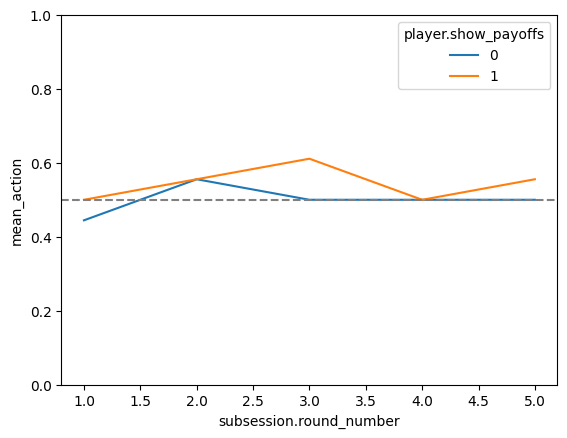

In [12]:
# round ごと，条件別の協力率
plt_df = df.group_by(["player.show_payoffs", "subsession.round_number"]).agg(
    pl.col("player.action").mean().alias("mean_action"),
)
# plt_df.glimpse()
ax = sns.lineplot(
    data=plt_df.to_pandas(),
    x="subsession.round_number",
    y="mean_action",
    hue="player.show_payoffs",
)
ax.axhline(0.5, color="gray", linestyle="--", label="50% Cooperation Rate")
ax.set_ylim(0, 1)